# Extended Wigner's friend scenario

An adapted notebook from Will pertaining to the extended Wigner's friend scenario.

This notebook is intended to run a benchmark to show a local friendliness violation from an extended Wigner's Friend scenario running on a QPU. For our friends we will use a GHZ state of increasing size. First we run on a simulator, then a noisy simulator, then on a real QPU.

Relevant References:
- [1]: ["A strong no-go theorem on the Wigner's friend paradox"](https://arxiv.org/abs/1907.05607)

- [2]: ["A scalable tripartite Wigner's friend scenario"](https://arxiv.org/abs/2109.02298)

- [3]: ["Thought experiments in a quantum computer"](https://arxiv.org/abs/2209.06236)

## Imports

In [1]:
from typing import Optional
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
from enum import Enum
from tqdm import tqdm

import qiskit
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram

## Constants

In [2]:
# Settings for extended Wigner's friend scenario.
class Setting(Enum):
    PEEK = 1
    REVERSE_1 = 2
    REVERSE_2 = 3

PEEK = Setting.PEEK.value
REVERSE_1 = Setting.REVERSE_1.value
REVERSE_2 = Setting.REVERSE_2.value
SETTINGS = [PEEK, REVERSE_1, REVERSE_2]

# Observers for scenario are Alice and Bob.
class Observer(Enum):
    ALICE = 0
    BOB = 1

ALICE = Observer.ALICE.value
BOB = Observer.BOB.value
OBSERVERS = [ALICE, BOB]
    
# Size of the bipartite quantum system.
SYS_SIZE = 2

# Size of the systems held by the "friends" (Charlie and Debbie).
CHARLIE_SIZE = 3
DEBBIE_SIZE = 3

# Two output bits for Alice and Bob.
MEAS_SIZE = 2

# Size of entire circuit
CIRCUIT_SIZE = SYS_SIZE + CHARLIE_SIZE + DEBBIE_SIZE

# Angles and beta term used for Alice and Bob measurement operators from arXiv:1907.05607.
# Note that despite the fact that degrees are used, we need to convert this to radians.
ANGLES = {PEEK: np.deg2rad(168), REVERSE_1: np.deg2rad(0), REVERSE_2: np.deg2rad(118)}
BETA = np.deg2rad(175)

# Standard |0> and |1> 
e0, e1 = np.asarray([1, 0]), np.asarray([0, 1])

In [3]:
# Ideal simulator backend.
backend = AerSimulator()
svsim = Aer.get_backend("statevector_simulator")

## State preparation

In [4]:
def prepare_bipartite_system() -> QuantumCircuit:
    """Generates the state: 1/sqrt(3) * (|00> + |01> + |10>)"""
    qc = QuantumCircuit(2)
    qc.ry(2 * np.arccos(np.sqrt(2/3)), 0)
    qc.ry(np.pi/4, 1)
    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)
    qc.ry(-np.pi/4, 1) 
    return qc

Confirm that the state preparation circuit generates $|\psi\rangle = \frac{1}{\sqrt{3}}\left(|00\rangle + |01\rangle + 10\rangle\right)$:

In [5]:
circuit = prepare_bipartite_system()
print(svsim.run(circuit).result().get_counts())

{'00': 0.333333333333333, '01': 0.333333333333333, '10': 0.333333333333333}


## CNOT ladder circuit

In [6]:
def cnot_ladder(system_qubit: int, friend_qubit: int, friend_size: int) -> QuantumCircuit:
    """CNOT ladder circuit (GHZ without Hadamard)."""
    circuit = QuantumCircuit(CIRCUIT_SIZE)
    for i in range(friend_size):
        circuit.cx(system_qubit, friend_qubit + i)
    return circuit

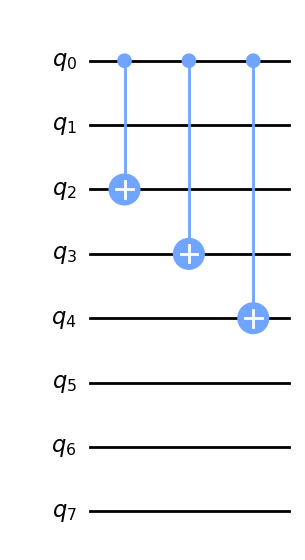

In [7]:
cnot_ladder(ALICE, SYS_SIZE, CHARLIE_SIZE).draw("mpl")

## Projective measurements for Alice and Bob

In [[1]](https://arxiv.org/pdf/1907.05607.pdf), the authors define a set of measurement operators for Alice and Bob as

$$
A_x = 2 \Pi_x^{a=1} - |0\rangle \langle 0| - |1 \rangle \langle 1|
\quad \text{and} \quad
B_y = 2 \Pi_y^{b=1} - |0\rangle \langle 0| - |1 \rangle \langle 1|
$$

where $\Pi_x^{a=1} = |\phi_x\rangle \langle \phi_x|$ and $\Pi_y^{b=1} = |\psi_y\rangle \langle \psi_y|$ project onto $|\phi_x\rangle$ and $|\psi_y\rangle$, respectively defined as

$$
|\phi_x\rangle = \frac{1}{\sqrt{2}} \left(|0\rangle + e^{i \theta_x} |1 \rangle \right)
\quad \text{and} \quad
|\psi_y\rangle = \frac{1}{\sqrt{2}} \left(|0\rangle + e^{i (\beta - \theta_y)} |1\rangle \right)
$$

such that $\theta_1 = 168^{\circ}, \theta_2 = 0^{\circ}, \theta_3 = 118^{\circ}$, and $\beta = 175^{\circ}$.

In [8]:
def phi(x: int) -> np.ndarray:
    return 1/np.sqrt(2) * (e0 + np.exp(1j * ANGLES[x]) * e1)

def psi(y: int) -> np.ndarray:
    return 1/np.sqrt(2) * (e0 + np.exp(1j * (BETA - ANGLES[y])) * e1)

def alice_measurement(x: int) -> np.ndarray:
    proj_a = np.outer(phi(x), phi(x))
    return 2 * proj_a - np.outer(e0, e0) - np.outer(e1, e1)

def bob_measurement(y: int) -> np.ndarray:
    proj_b = np.outer(psi(y), psi(y))
    return 2 * proj_b - np.outer(e0, e0) - np.outer(e1, e1)

We want to write these measurements in terms of the $Rx(\alpha)$ and $Rz(\gamma)$ acting
on $|0\rangle$ as follows:

$$
|\psi\rangle = Rx(\alpha) R_z(\gamma) |0\rangle.
$$

The $Rz(\gamma)$ gate acts first on $|0\rangle$:

$$
Rz(\gamma)|0\rangle = e^{-i\gamma/2}|0\rangle.
$$

Then, the $Rx(\alpha)$ gate acts on this state:

$$
Rx(\alpha)e^{-i \gamma/2}|0\rangle = 
e^{-i\gamma/2}\cos(\alpha/2)|0\rangle - i e^{-i \gamma/2} \sin(\alpha/2) |1\rangle.
$$

To find $\alpha$ and $\gamma$ that result in $|\phi_x\rangle$ or $|\psi_y\rangle$, we should equate this expression to the desired states $|\phi_x\rangle$ and $|\psi_y\rangle$.

For Alice's state $|\phi_x\rangle$:

$$
|\phi_x\rangle = \frac{1}{\sqrt{2}} \left(|0\rangle + e^{i \theta_x} |1\rangle \right).
$$

We can write:

$$
e^{-i\gamma/2}\cos(\alpha/2)|0\rangle - ie^{-i\gamma/2}\sin(\alpha/2)|1\rangle = \frac{1}{\sqrt{2}} \left(|0\rangle + e^{i \theta_x} |1\rangle \right).
$$

From the above equation, we can set the coefficients for $|0\rangle$ and $|1\rangle$ equal on both sides to find:

$$
\alpha = 2 \arccos \left(\frac{1}{\sqrt{2}}\right) = \frac{\pi}{2}
\quad \text{and} \quad
\gamma = -\theta_x.
$$

Similarly, for Bob's state $|\psi_y\rangle$:

$$
|\psi_y\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{i(\beta - \theta_y)}|1\rangle\right)
$$

to be achieved by these rotation gates, we find:

$$
\alpha = \frac{\pi}{2} 
\quad \text{and} \quad
\gamma = \beta - \theta_y.
$$


## Circuit for extended Wigner's friend scenario

In [9]:
def ewfs(alice_setting: Setting, bob_setting: Setting) -> QuantumCircuit:
    """Generate the circuit for extended Wigner's friend scenario."""    
    # Observable circuits
    charlie_obs = cnot_ladder(ALICE, SYS_SIZE, CHARLIE_SIZE)
    debbie_obs = cnot_ladder(BOB, SYS_SIZE + CHARLIE_SIZE, DEBBIE_SIZE)
        
    # Initialize circuit that defines the extended scenario.
    qc = QuantumCircuit(CIRCUIT_SIZE, MEAS_SIZE)
    
    # State prep
    qc = qc.compose(prepare_bipartite_system())    

    # Apply observable circuits for Charlie and Debbie.
    qc = qc.compose(charlie_obs)
    qc = qc.compose(debbie_obs)   
    
    # 0: Charlie system; 2: Charlie; [0]: Alice
    if alice_setting is PEEK:
        # Ask Charlie for the outcome. We pick a random qubit from Charlie's register.
        random_offset = random.randint(0, CHARLIE_SIZE-1)
        qc.measure(SYS_SIZE + random_offset, ALICE)
    else:
        # Undo the measurement
        qc = qc.compose(charlie_obs)
        
        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.
        qc.rz(np.pi/2, ALICE)
        qc.rx(-ANGLES[alice_setting], ALICE)
        
        qc.measure(ALICE, ALICE)
    
    # 1: Debbie system; 3: Debbie; [1]: Bob
    if bob_setting is PEEK:
        # Ask Debbie for the outcome. We pick a random qubit from Debbie's register.
        random_offset = random.randint(0, DEBBIE_SIZE-1)
        qc.measure(SYS_SIZE + CHARLIE_SIZE + random_offset, BOB)
    else:
        # Undo the measurement
        qc = qc.compose(debbie_obs)    

        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.    
        qc.rz(np.pi/2, BOB)
        qc.rx(BETA - ANGLES[bob_setting], BOB)

        qc.measure(BOB, BOB)    
        
    return qc

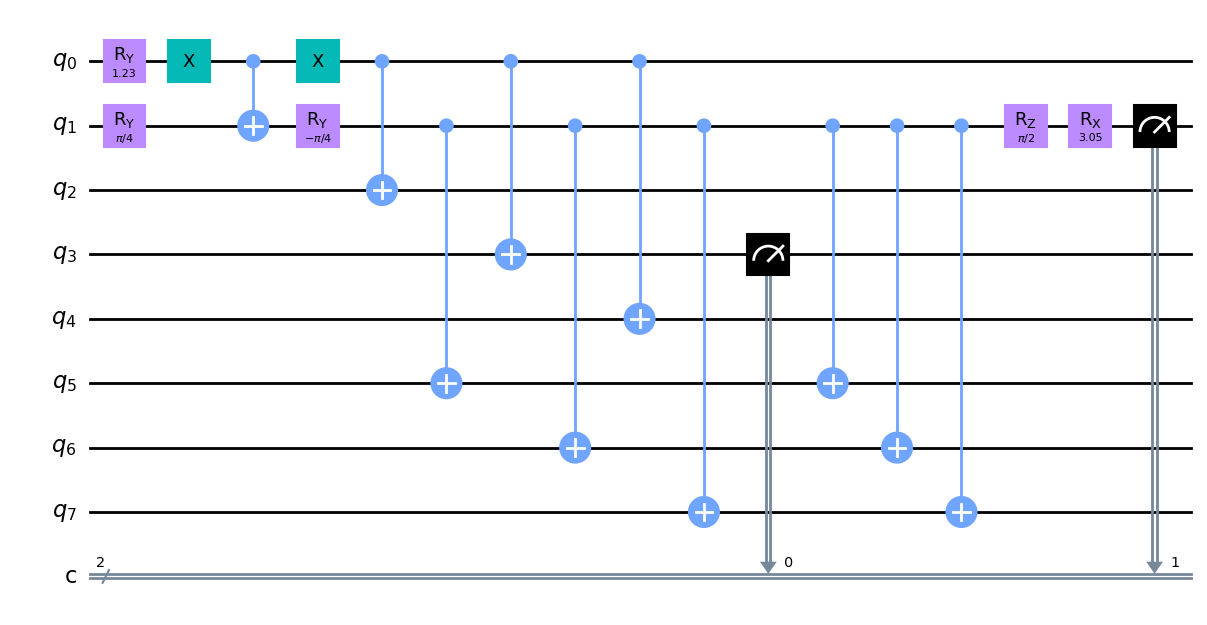

In [10]:
qc = ewfs(PEEK, REVERSE_1)
qc.draw("mpl")

In [11]:
ewfs_circuit = ewfs(PEEK, PEEK)

result = backend.run(ewfs_circuit).result()
counts = result.get_counts(0)
print(f"Counts: {counts}")

Counts: {'01': 337, '00': 313, '10': 374}


## Consider all experimental settings

In [12]:
def generate_all_experiments():
    """Generate probabilitites for all combinations of experimental settings."""
    all_experiment_combos = list(itertools.product(SETTINGS, repeat=2))

    results = {}
    for alice, bob in all_experiment_combos:
        ewfs_circuit = ewfs(alice, bob)
        result = backend.run(ewfs_circuit).result()
        counts = result.get_counts(0)

        # Convert counts to probabilities.
        total_shots = sum(counts.values())
        probabilities = {key: value / total_shots for key, value in counts.items()}

        results[(alice, bob)] = probabilities
    return results

## Expectation values

In [13]:
def marginalize(bitstring_probs, indices):
    marginalized_probs = {}
    for bitstring, prob in bitstring_probs.items():
        # Extract the bits at the specified indices.
        marginalized_bitstring = "".join([bitstring[i] for i in indices])
        
        # Add the probability to the marginalized_probs dictionary.
        if marginalized_bitstring in marginalized_probs:
            marginalized_probs[marginalized_bitstring] += prob
        else:
            marginalized_probs[marginalized_bitstring] = prob
            
    return marginalized_probs

In [14]:
def single_expect(observer: Observer, setting: Setting, results: dict): #obs = 0 for Alice and 2 for Bob
    """Expectation value of single operator."""
    expect, denom = 0, 0
    for settings, probs in results.items():
        if settings[observer] is setting:
            expect += marginalize(probs, [observer])["1"]
            denom += 1
    return expect / denom

In [15]:
def double_expect(settings, results):
    """Expectation value of product of two operators."""
    probs = results[settings]
    try:
        val = probs["11"]
    except KeyError:
        val = 0
    return val

## Inequalities

In [16]:
results = generate_all_experiments()

In [17]:
A1 = single_expect(ALICE, PEEK, results)
B1 = single_expect(BOB, PEEK, results)

A2 = single_expect(ALICE, REVERSE_1, results)
B2 = single_expect(BOB, REVERSE_1, results)

A3 = single_expect(ALICE, REVERSE_2, results)
B3 = single_expect(BOB, REVERSE_2, results)

A1B1 = double_expect((PEEK, PEEK), results)
A1B2 = double_expect((PEEK, REVERSE_1), results)
A1B3 = double_expect((PEEK, REVERSE_2), results)

A2B1 = double_expect((REVERSE_1, PEEK), results)
A2B2 = double_expect((REVERSE_1, REVERSE_1), results)
A2B3 = double_expect((REVERSE_1, REVERSE_2), results)

A3B1 = double_expect((REVERSE_2, PEEK), results)
A3B2 = double_expect((REVERSE_2, REVERSE_1), results)
A3B3 = double_expect((REVERSE_2, REVERSE_2), results)

In [18]:
# Local-friendliness inequalities:
# Eq. (13) from [1].
lf_1 = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
# Eq. (14) from [1].
lf_2 = -A1 - A2 - A3 - B1 - A1B1 - A2B1 - A3B1 - 2*A1B2 + A2B2 + A3B2 - A2B3 + A3B3 - 5
# Eq. (15) from [1].
lf_3 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 
# Eq. (16) from [1].
lf_4 = -A2 - A3 - B2 - B3 - A1B2 + A1B3 - A2B1 - A2B2 - A2B3 + A3B1 - A3B2 - A3B3 - 4

# Brukner inequalities:
# Eq. (17) from [1].
brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2
# Eq. (18) from [1].
semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2

# Positivity inequalities:
# Eq. (19) from [1].
pos_1 = 1 + A1 + B1 + A1B1
# Eq. (20) from [1].
pos_2 = 1 + A1 + B2 + A1B2
# Eq. (21) from [1].
pos_3 = 1 + A2 + B2 + A2B2

print("******Inequalities******")
print(f"semi-brukner: {semi_brukner} -- is violated: {semi_brukner > 0}")
print(f"brukner: {brukner} -- is violated: {brukner > 0}")
print(f"lf_1: {lf_1} -- is violated: {lf_1 > 0}")
print(f"lf_2: {lf_2} -- is violated: {lf_2 > 0}")
print(f"lf_3: {lf_3} -- is_violated: {lf_3 > 0}")
print(f"lf_4: {lf_4} -- is_violated: {lf_4 > 0}")
print(f"pos_1: {pos_1} -- is_violated: {pos_1 < 0}")
print(f"pos_2: {pos_2} -- is_violated: {pos_2 < 0}")
print(f"pos_3: {pos_3} -- is_violated: {pos_3 < 0}")
print("**************************")

******Inequalities******
semi-brukner: -2.8408203125 -- is violated: False
brukner: -2.1650390625 -- is violated: False
lf_1: -8.408854166666666 -- is violated: False
lf_2: -6.629231770833334 -- is violated: False
lf_3: -4.9677734375 -- is_violated: False
lf_4: -6.798177083333333 -- is_violated: False
pos_1: 1.8792317708333335 -- is_violated: False
pos_2: 2.1985677083333335 -- is_violated: False
pos_3: 2.2151692708333335 -- is_violated: False
**************************
